<a href="https://colab.research.google.com/github/Melissa-cv/Informe1_biose-ales/blob/main/practica_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PRACTICA 3 = parte 1=8 marzo, parte 2=22 de marzo (hay sustentación)
la estructura interna es como diccionario, se encuentra una señal filtrada y no filtrada, se crea un vector de tiempo que depende de la frecuencia de muestreo (fs), se identifica de un ciclo a un ciclo con un pico (en la ECG), se asume que son independientes, en esta práctica se busca mirar si es determinista la señal, con todas las pruebas.(entrega 8 de marzo)

EEG, tienen canales y epocas, cada electrodo es un canal, a los segmentos de tiempo de los canales se les conoce como epocas.
analizar el valor p
y debe tener concluisonesen los repositorios no se suben los datos
hay una archivo llamado .gitinore, decir que se ignore la carpeta donde estan los datos o tener otra ruta de carpeta de los datos, aparte del codigo(revisar los tipos de rutas)



In [ ]:
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from statsmodels.tsa.stattools import adfuller

Primero se debe cargar el archivo y para esto debemos importar la funcion que nos permita traerla a nuestro código


In [ ]:
from google.colab import files

Debemos cargar nuestra base de datos para poder trabajar en ella

In [ ]:
load = files.upload()

Saving signals.mat to signals.mat


En nuestro caso, al estar trabajando con una base de datos de MATLAB, debemos cargar el archivo .mat mediante la función scipy.io.loadmat ya que contiene  variables y matrices que fueron guardadas desde MATLAB

In [ ]:
data = scipy.io.loadmat('/content/signals.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'ECG_asRecording', 'ECG_filtered', 'EMG_filtered1', 'EMG_filtered2', 'EMG_asRecording1', 'EMG_asRecording2'])

Para poder trabajar sobre los datos que tenemos debemos primero acceder a ellos, en este caso los datos que traemos son los del ECG sin procesar en la variable ECG y a los datos de ECG filtrados en la variable ECG_filtered. Ya con estas variables vamos a realizar análisis, procesamiento y visualización de los datos de ECG.

In [ ]:
ECG=data['ECG_asRecording']
ECG_filtered=data['ECG_filtered']

Aqui simplemente visualizamos los datos guardados en la variable ECG_filtered

In [ ]:
ECG_filtered

array([[ 8.87103896e-03,  5.62737497e+01,  8.57077127e+01, ...,
        -1.20952610e+02, -1.31734356e+02, -1.32898021e+02]])

Realizamos un código de prueba

In [ ]:
filas, columnas = ECG_filtered.shape
n_filas=filas
n_columnas=columnas
print(n_columnas)
print(n_filas)

30720
1


Aqui simplemente visualizamos los datos guardados en la variable ECG

In [ ]:
ECG

array([[3904.31689453, 3939.203125  , 3976.00683594, ..., 4366.41064453,
        4365.31103516, 4370.91796875]])

Primero, se define el período de muestreo como la inversa de la frecuencia de muestreo, que es 1024 muestras por segundo en nuestro caso, de allí creamos un arreglo de puntos de tiempo que van desde 0 hasta el tiempo total de la señal de ECG filtrada, con incrementos de tiempo igual al período de muestreo, para esto, usamos la función np.arange(0, ECG_filtered.size * T, T)

In [ ]:
T=1/1024
np.arange(0,ECG_filtered.size*T,T)


array([0.00000000e+00, 9.76562500e-04, 1.95312500e-03, ...,
       2.99970703e+01, 2.99980469e+01, 2.99990234e+01])

Luego, se crea un arreglo de puntos de tiempo (t) para los datos de ECG filtrados, de allí convertimos los datos de ECG filtrados en un arreglo unidimensional, ya que no se graficaban correctamente debido a la estructura de los datos y asi poder graficar los datos de ECG filtrados en función del tiempo utilizando matplotlib.

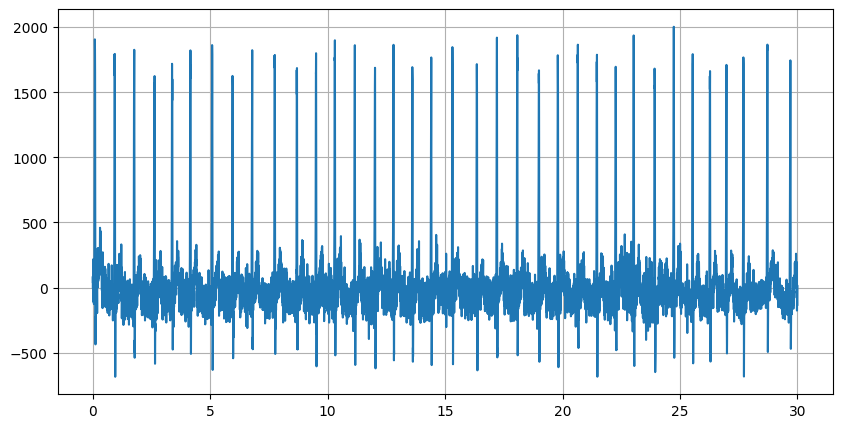

In [ ]:
T=1/1024
t=np.arange(0,ECG_filtered.size*T,T)
ECG_filtered = ECG_filtered.flatten()

plt.figure(figsize=(10, 5))
plt.plot(t,ECG_filtered)
plt.grid(True)
plt.show()


Para la señal de ECG, también se crea un arreglo de puntos de tiempo (t) para los datos de ECG filtrados, de allí convertimos los datos de ECG sin filtrar en un arreglo unidimensional, ya que no se graficaban correctamente debido a la estructura de los datos y asi poder graficar los datos de ECG sin filtrar en función del tiempo utilizando matplotlib.

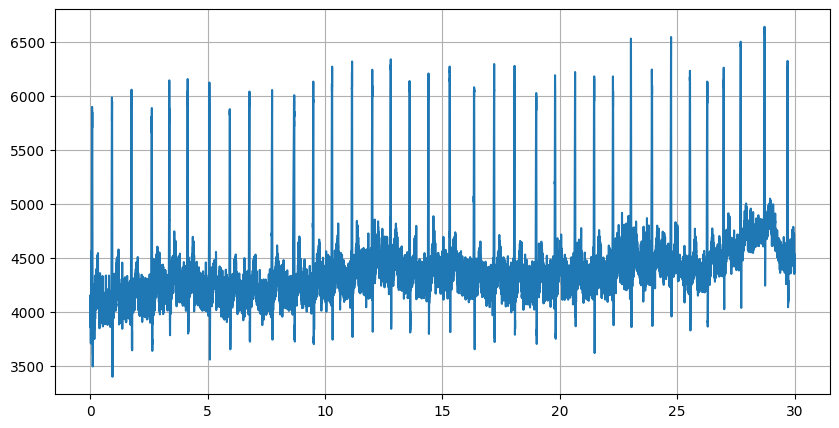

In [ ]:
T=1/1024
t=np.arange(0,ECG.size*T,T)
ECG = ECG.flatten()

plt.figure(figsize=(10, 5))
plt.plot(t,ECG)

plt.grid(True)
plt.show()

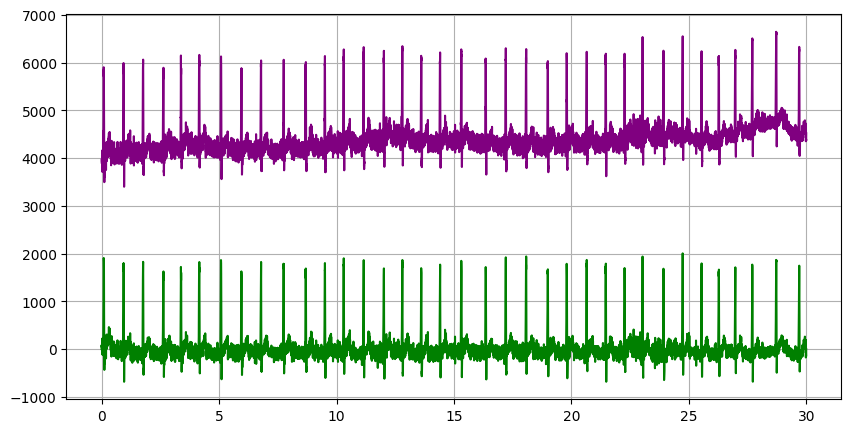

In [ ]:
T=1/1024
t=np.arange(0,ECG.size*T,T)
ECG = ECG.flatten()

plt.figure(figsize=(10, 5))
plt.plot(t,ECG, 'purple')
plt.plot(t,ECG_filtered,'g')
plt.grid(True)
plt.show()

En la señal sin filtrar se puede observar que hay picos irregulares, además tenemos una señal con mayor variabilidad lo que no permite observar bien las ondas P, QRS, T y U, a diferencia de la señal filtrada que se observan alrededor de 6 picos en 10 segundos, lo que indicaría una frecuencia cardíaca de aproximadamente 60 latidos por minuto (LPM). En la señal sin filtrar lo que se puede usar para no tener una señal con tanta variabilidad es utilizar un filtro pasa bajas, que permite el paso de las bajas frecuencias e impide las de altas frecuencias, al realizar un estudio de ECG se puede tener ruido de muy altas frecuencias como el del movimiento del paciente, actividad muscular o incluso interferencia de otros dispositivos que se encuentren cerca, mientras que las ondas cardiacas son de baja frecuencia.


Ahora, como necesitamos graficar 1 ciclo lo que hacemos es seleccionar un segmento de la señal de ECG el cual va desde el índice c_i hasta el índice c_f y lo asignamos a la variable ECG_ciclo para luego poder finalmente graficar el segmento.

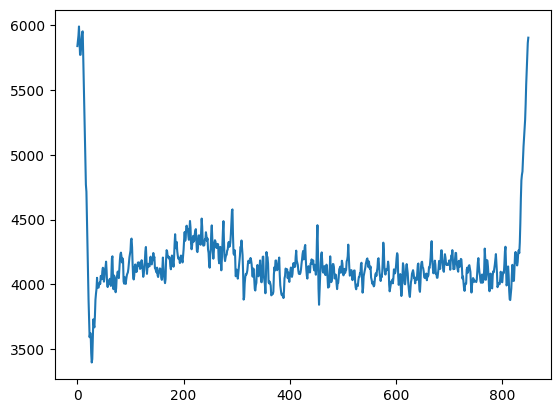

In [ ]:
c_i = 950
c_f = 1800

ECG_ciclo = ECG[c_i:c_f]
plt.plot(ECG_ciclo)

Para encontrar los puntos máximos de la señal, usamos la función find_peaks y le asignamos una distancia mínimas entre picos para que me pueda arrojar diferentes valores teniendo en cuenta este parámetro y finalmente se muestran los máximos para poder operar con estos valores posteriormente

In [ ]:
maximos=find_peaks(ECG, distance=800)
print(maximos)

(array([   88,   953,  1807,  2645,  3454,  4256,  5203,  6092,  6950,
        7936,  8902,  9733, 10555, 11424, 12304, 13111, 13929, 14755,
       15677, 16743, 17619, 18509, 19453, 20273, 21147, 21981, 23583,
       24493, 25332, 26155, 27128, 28367, 29406, 30411]), {})


Para encontrar los picos máximos en la señal de ECG creamos una función llamada picos(), la función selecciona el primer ciclo de ECG entre los dos primeros picos máximos, y lo graficamos y Luego encontramos algunas valores de la señal de ECG seleccionada, como el promedio, el valor RMS, la varianza y la desviación estándar que nos sirve para hacer el analisis posterior.

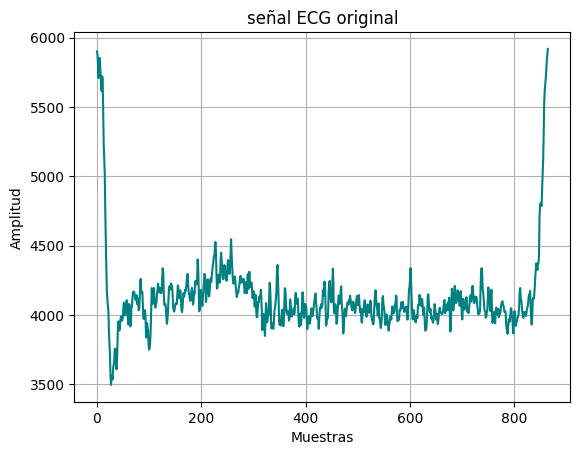

el promedio de la señal original es:  4131.136266878161
el RMS de la señal oroginal es: 4142.454957820607
la varianza de la señal original es: 93646.2220564969
la desviación estandar de la señal original es: 306.01670225086883


In [ ]:
def picos(ECG):
    maximos, _ = find_peaks(ECG, distance=850)

    max1 = maximos[0]
    max2 = maximos[1]


    ciclo_ECG = ECG[max1:max2]

    plt.plot(ciclo_ECG,'teal')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.title('señal ECG original')
    plt.grid()
    plt.show()

    return ciclo_ECG

ciclo_ECG = picos(ECG)
prom = np.mean(ciclo_ECG)
print('el promedio de la señal original es: ',prom)
rms = np.sqrt(np.mean(np.square(ciclo_ECG)))
print('el RMS de la señal oroginal es:', rms)
var = np.var(ciclo_ECG)
print('la varianza de la señal original es:', var )
des_estandar = np.std(ciclo_ECG)
print('la desviación estandar de la señal original es:', des_estandar )


El primedio gráfica la tendencia central de la señal, en este caso es de 4131.13, lo que significa que el valor medio de la señal esta por ese valor.

En el cado del RMS es un valor que se toma efectivo de la señal, es comúm mente utilizado para expresar la amplitud de señales variables en el tiempo como en nuestro caso el ECG.

La varianza es una medida de dispersión que indica cuánto varíana los valores de la señal al rededor de su media.

La desviación estándar esta indica cuanto se alejan los valores individuales de la media.

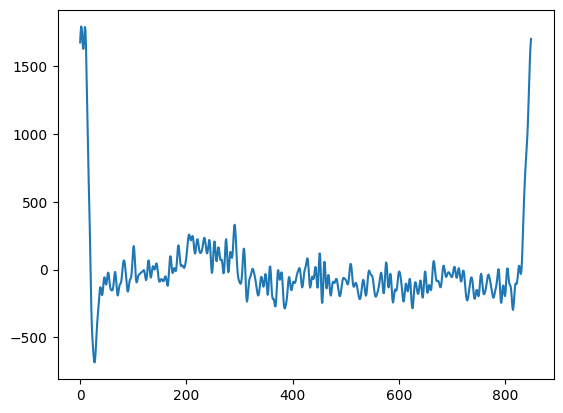

In [ ]:
inicio= 950
fin= 1800
filtered_ciclo = ECG_filtered[inicio:fin]
plt.plot(filtered_ciclo)

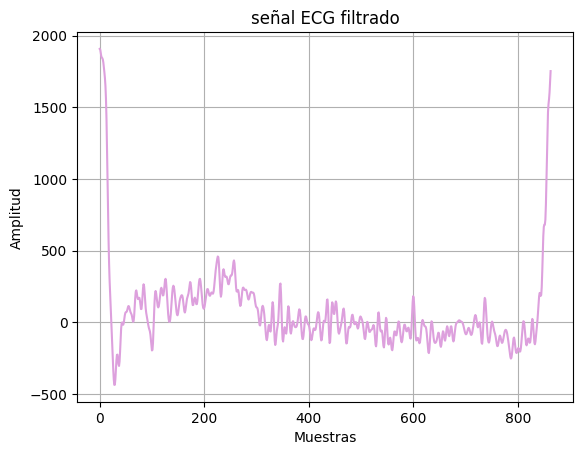

el promedio de la señal filtrado es:  74.00995782055861
el RMS de la señal filtradol es: 319.62757818893766
la varianza de la señal filtrado es: 96684.31488232457
la desviación estandar de la señal filtrado es: 310.94101511753735


In [ ]:
def picos_filtro(ECG_filtered):
    maximos, _ = find_peaks(ECG_filtered, distance=850)

    max1 = maximos[0]
    max2 = maximos[1]


    ciclo_filtered = ECG_filtered[max1:max2]

    plt.plot(ciclo_filtered,'plum')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.title('señal ECG filtrado')
    plt.grid()
    plt.show()

    return ciclo_filtered

ciclo_filtered = picos_filtro(ECG_filtered)
prom = np.mean(ciclo_filtered)
print('el promedio de la señal filtrado es: ',prom)
rms = np.sqrt(np.mean(np.square(ciclo_filtered)))
print('el RMS de la señal filtradol es:', rms)
var = np.var(ciclo_filtered)
print('la varianza de la señal filtrado es:', var )
des_estandar = np.std(ciclo_filtered)
print('la desviación estandar de la señal filtrado es:', des_estandar )


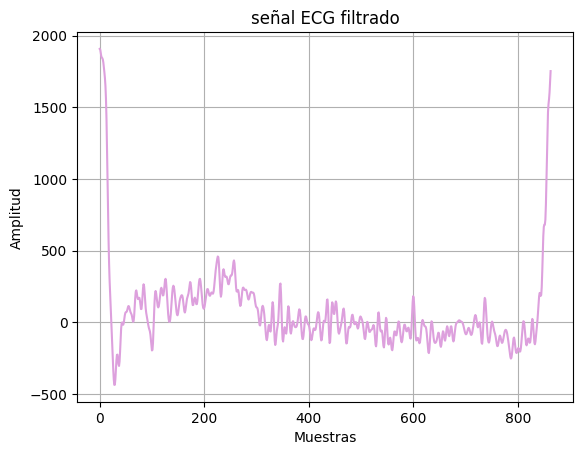

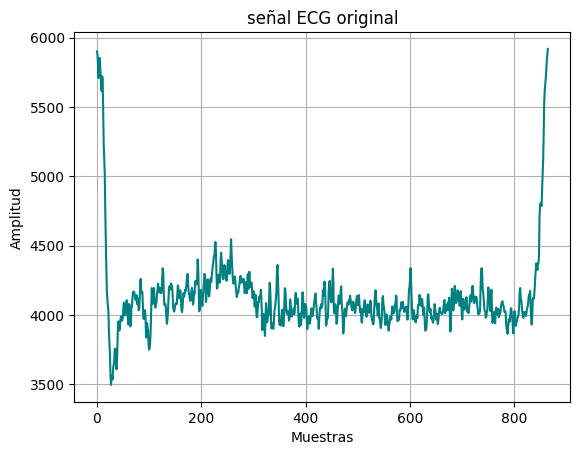

In [ ]:
ciclo_filtered = picos_filtro(ECG_filtered)
ciclo_ECG = picos(ECG)

Las señales difieren en lo que podríamos llamar 'suavidad', como se puede observar el ciclo de la señal filtrada tiene menos ruido, esto se debe a que ya se aplico un filtro en el cual se disminuye el ruido de los posibles artefactos como lo es la actividad muscular, el movimiento del paciente, entre otras, como anteriormente se habia mencionado.

los promedios en orden son: 98.76212104547919
los promedios en orden son: -13.5044187637702
los promedios en orden son: -4.937350266906564
los promedios en orden son: -2.1915198526014628
los promedios en orden son: -15.886084539947237
los promedios en orden son: -5.5217999300734375
los promedios en orden son: 28.790337295480967
los promedios en orden son: -9.166265452820877
los promedios en orden son: 3.3630744058432085
los promedios en orden son: 8.173305574324381
los promedios en orden son: 4.201570714904338
los promedios en orden son: -23.59663727580078
los promedios en orden son: -0.664681761384616
los promedios en orden son: 15.846440943661433
los promedios en orden son: -3.473655923133829


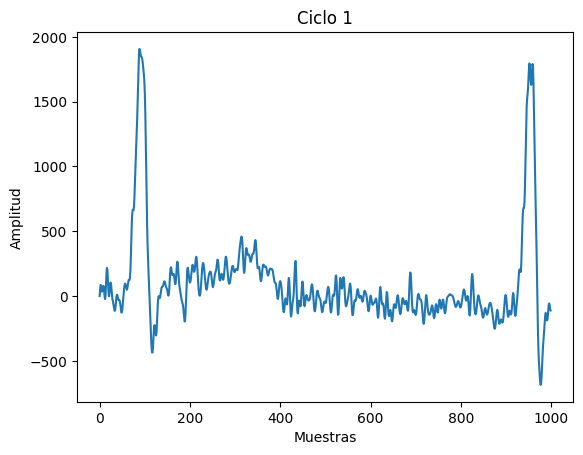

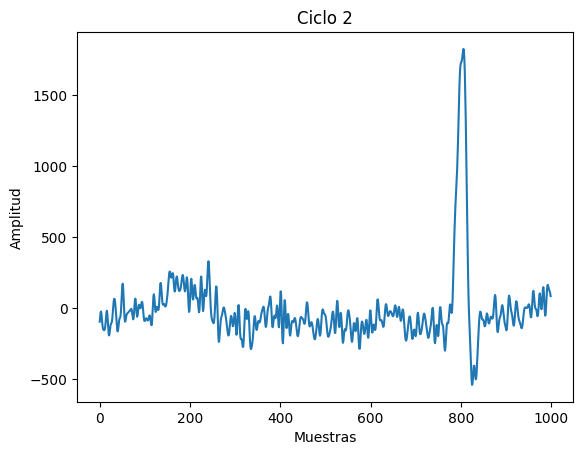

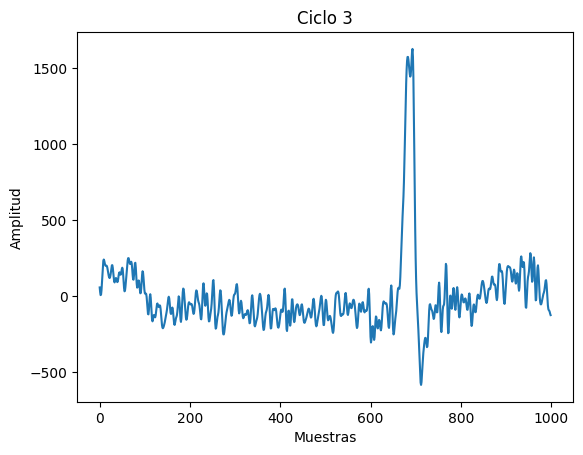

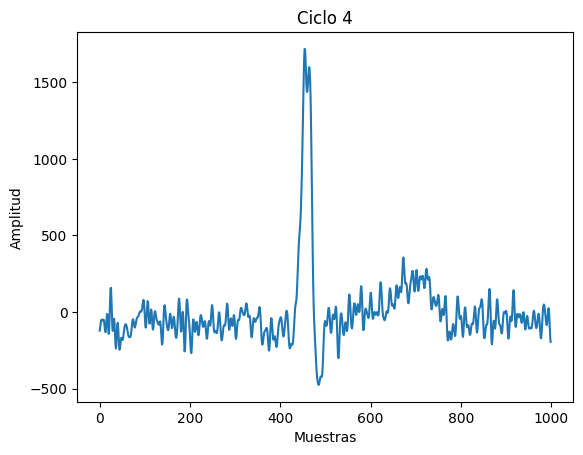

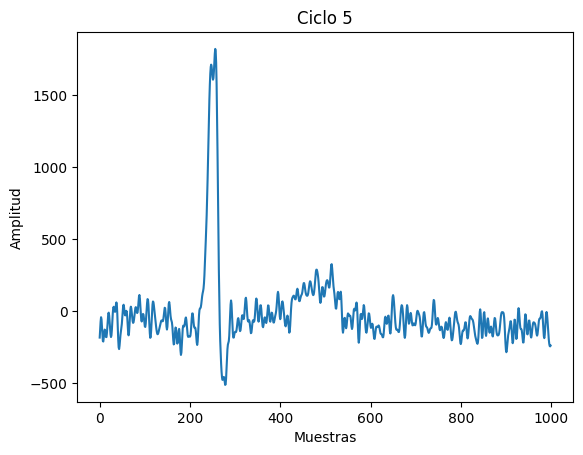

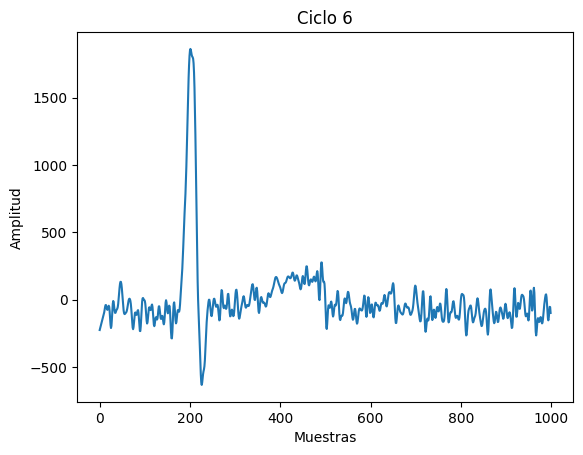

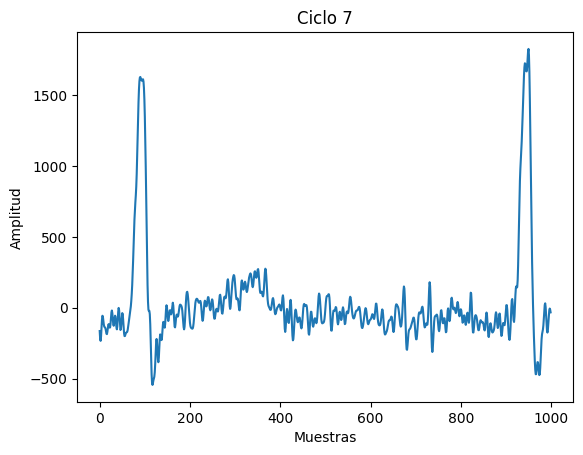

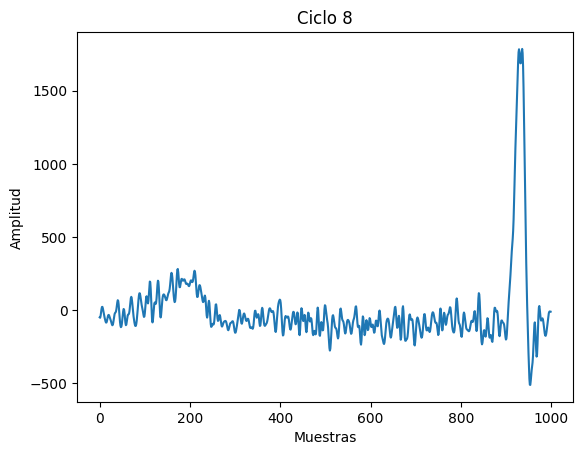

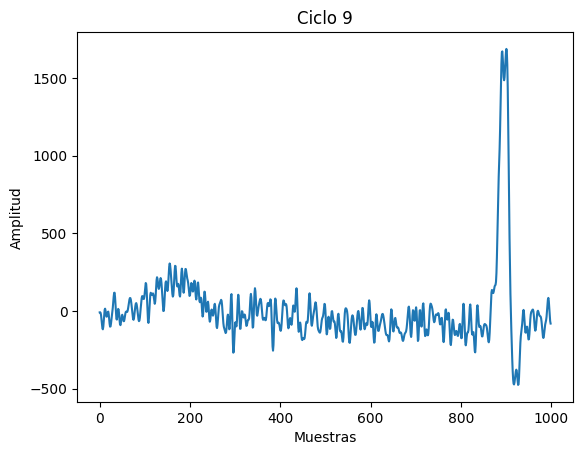

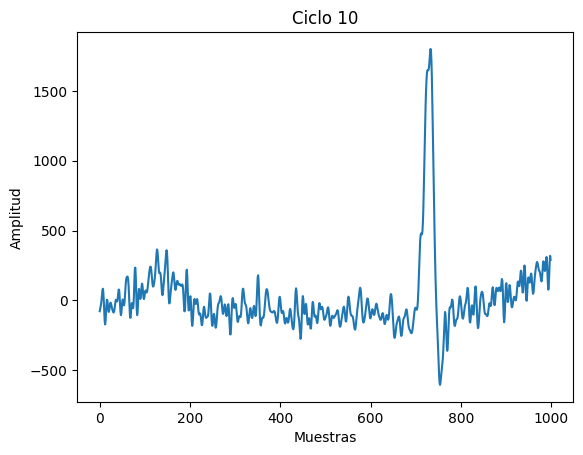

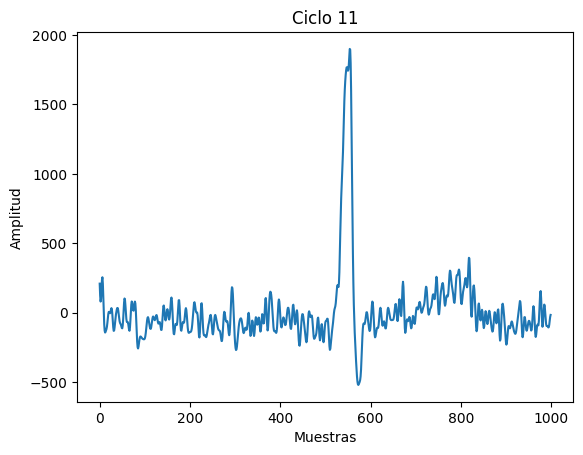

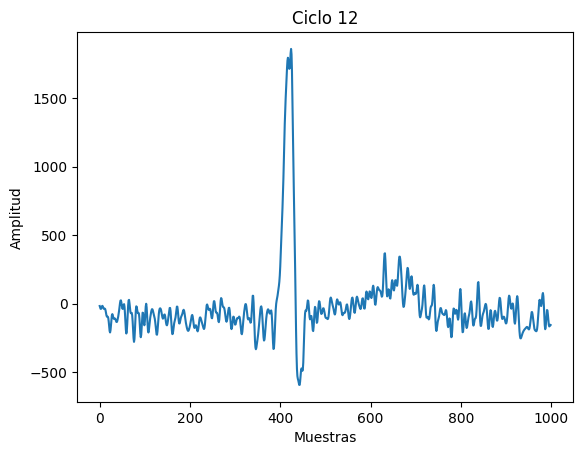

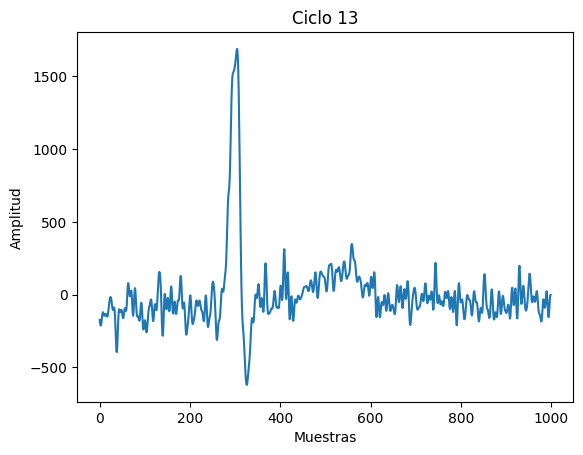

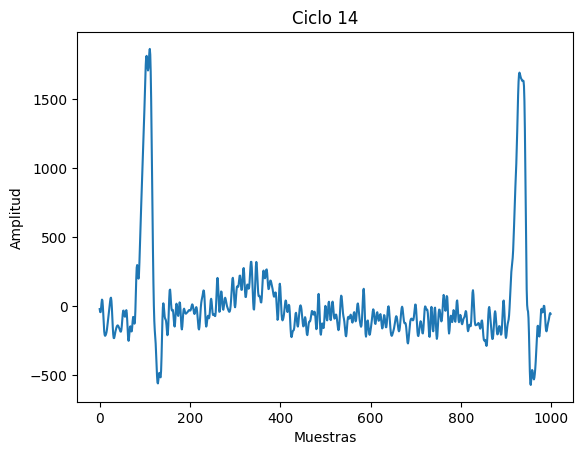

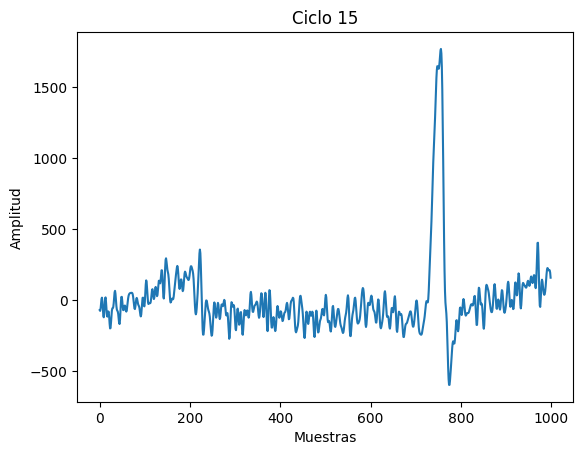

Promedio global de los ciclos: 5.3462957475502995
Varianza global de los ciclos: 83811.50817729275


In [ ]:
def extraer_ciclos(ECG_filtered, num_ciclos):
    ciclos = []
    promedios = []
    varianzas = []

    longitud_ciclo = 1000


    for i in range(num_ciclos):
        inicio = i * longitud_ciclo
        fin = inicio + longitud_ciclo

        ciclo = ECG_filtered[inicio:fin]
        ciclos.append(ciclo)

        promedio_ciclo = np.mean(ciclo)
        print('los promedios en orden son:', promedio_ciclo)
        varianza_ciclo = np.var(ciclo)

        promedios.append(promedio_ciclo)
        varianzas.append(varianza_ciclo)

    return ciclos, promedios, varianzas

ciclos, promedios, varianzas = extraer_ciclos(ECG_filtered, num_ciclos=15)

for i, ciclo in enumerate(ciclos):

    plt.plot(ciclo)
    plt.title(f"Ciclo {i+1}")
    plt.xlabel("Muestras")
    plt.ylabel("Amplitud")
    plt.show()


promedio_global = np.mean(promedios)
varianza_global = np.mean(varianzas)

print("Promedio global de los ciclos:", promedio_global)
print("Varianza global de los ciclos:", varianza_global)

Las ondas ECG se consideran estacionarias las cuales son las que no cambian con el tiempo, esto debido a la onda P y el complejo QRS, sin embargo, en algunos casos dados ya sea por fallos del equipo o enfermedades cardiacas, estas pueden convertirse en no estacionarias.

Ahora, con el analisis realizado de los promedios, se puede observar que entre ellos cambian de forma significativa el promedio, he incluso el promedio del ciclo gráficado anteriormente al promedio global se puede observar una variación muy alta, lo que nos da a entender que es una onda no estacionaria.

Por otro lado se debe tener en cuenta que al sacar cada uno de los ciclos, se tomo el mismo rango de señal, sin embargo no se hizo de pico a pico, lo que podría generar un error o que no sea confiable la comparación.

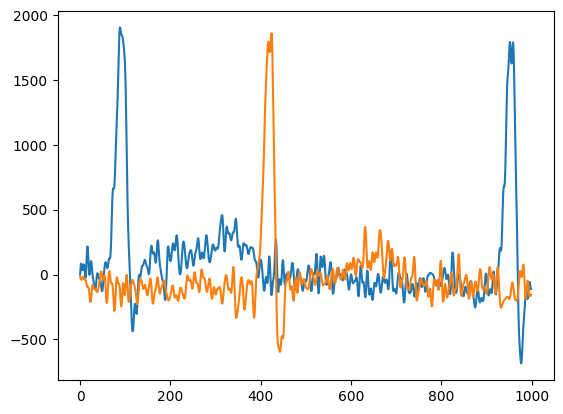

In [ ]:
ciclo1=ciclos[0]
ciclo2=ciclos[11]

plt.plot(ciclo1)
plt.plot(ciclo2)

In [ ]:
_,p1 = shapiro(ciclo1)
_,p2 = shapiro(ciclo2)
print('valor de la prueba de normalidad del ciclo 1:',p1)
print('valor de la prueba de normalidad del ciclo 2:',p2)


_, p_levene = levene(ciclo1, ciclo2)
print('valor de la prueba Levene:',p_levene)
if p1 > 0.05 and p2 > 0.05 and p_levene > 0.05:
    resultado_t, valor_t = ttest_ind(ciclo1, ciclo2)
    print("La comparación es una prueba t:")
    print("Estadístico t:", resultado_t)
    print("Valor p de la prueba t:", valor_t)

    if valor_t < 0.5:
        print("Se puede observar una diferencia significativa en los ciclos")
    else:
        print("No se observa una diferencia significativa en los ciclos")
else:

    resultado_m, valor_p_m = mannwhitneyu(ciclo1, ciclo2)
    print("la comparación es una prueba U de Mann-Whitney:")
    print("Estadístico U:", resultado_m)
    print("Valor p:", valor_p_m)

    if valor_p_m < 0.05:
        print("Existe una diferencia significativa entre los ciclos.")
    else:
        print("No hay una diferencia significativa entre los ciclos.")




valor de la prueba de normalidad del ciclo 1: 4.083383725042517e-41
valor de la prueba de normalidad del ciclo 2: 4.203895392974451e-45
valor de la prueba Levene: 5.49022363586592e-08
la comparación es una prueba U de Mann-Whitney:
Estadístico U: 666183.0
Valor p: 6.70724487134634e-38
Existe una diferencia significativa entre los ciclos.


Analizando el ciclo 1 y 2 que tomamos, se puede observar inicialmente cuando se realiza una prueba de normalidad (función Shapiro), en la cual la H0 dice que los datos no siguen una distribución normal, por su parte la H1 sugiere que los datos no se presentan con una distribución normal, en el caso de ambos ciclos la prueba arroja un resultado menor al nivel de significancia (tomado para este caso como 0.05), lo que indica que se rechaza la hipotesis nula en este caso, es decir que sugiere que los datos no contienen una distribución normal.

Ahora se analiza la prueba Leavene que se utiliza para evaluar si las varianzas de dos o más grupos de datos son iguales, para esto se toma el mismo nivel de significancia del anterior (0.05) y se realiza la misma comparación si el valor de la prueba es menor, entonces se rechaza la hipotesis nula y se dice que si hay diferencias significativas en la varianza de los grupos. Observando los resultados entonces en nuestro caso no se rechaza la hipotesis nula la cual sugiere que no tienen varianza iguales.

Para poder realizar la prueba t, se debe cumplir con los supuestos de normalidad y varianza, pero en nuestro caso la prueba de shapiro sugiere que no se distribuyen de forma normal, pero se cumple con la varianza.

la prueba Mann-Whitney se utiliza para comparar muestras independientes(la independencia se especifica en el ejercicio  propuesto) y determina si una muestra tiene valores significativamente diferentes, para realizar este analisis se calcula el valor de p por medio de la función mannwhitneyu, y se compara con el nivel de significancia (0.05), si el valor p es menor entonces se rechaza la hipotesis nula (no hay diferencia significativa), y se sugiere que si hay una diferencia significativa, en el caso de estos dos ciclos (ciclo1 y ciclo2), el p es menor que la significancia por lo tanto se rechaza la hipotesis nula y se toma si existe una diferencia significativa




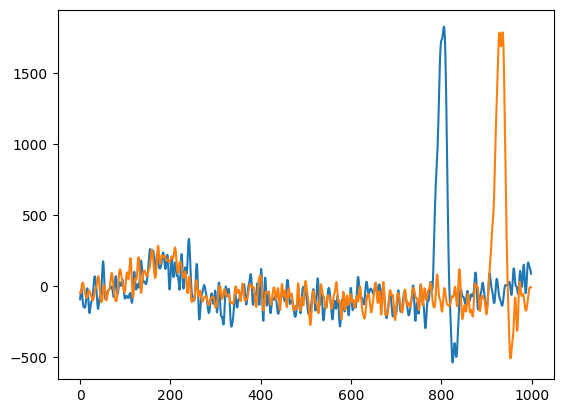

In [ ]:
ciclo3=ciclos[1]
ciclo4=ciclos[7]

plt.plot(ciclo3)
plt.plot(ciclo4)

In [ ]:
_,p3 = shapiro(ciclo3)
_,p4 = shapiro(ciclo4)
print(p3)
print(p4)


_, p_levene = levene(ciclo3, ciclo4)
print(p_levene)
if p3 > 0.05 and p4 > 0.05 and p_levene > 0.05:
    resultado_t, valor_p_t = ttest_ind(ciclo3, ciclo4)
    print("Prueba t:")
    print("Estadístico t:", resultado_t)
    print("Valor p:", valor_p_t)

    if valor_p_t < 0.5:
        print("Existe una diferencia significativa entre los ciclos.")
    else:
        print("No hay una diferencia significativa entre los ciclos.")
else:
    resultado_mannwhitneyu, valor_p_mannwhitneyu = mannwhitneyu(ciclo3, ciclo4)
    print("Prueba U de Mann-Whitney:")
    print("Estadístico U:", resultado_mannwhitneyu)
    print("Valor p:", valor_p_mannwhitneyu)

    if valor_p_mannwhitneyu < 0.05:
        print("Existe una diferencia significativa entre los ciclos.")
    else:
        print("No hay una diferencia significativa entre los ciclos.")

1.401298464324817e-44
1.401298464324817e-45
0.48825816036571634
Prueba U de Mann-Whitney:
Estadístico U: 499040.0
Valor p: 0.9407685127995674
No hay una diferencia significativa entre los ciclos.


Ya para este caso, analizando el ciclo 3 y 4 que tomamos, se puede observar inicialmente cuando se realiza una prueba de normalidad (función Shapiro), en la cual la H0 dice que los datos no siguen una distribución normal, por su parte la H1 sugiere que los datos no se presentan con una distribución normal, en el caso de ambos ciclos la prueba arroja un resultado menor al nivel de significancia (tomado para este caso como 0.05), lo que indica que se rechaza la hipotesis nula en este caso, es decir que sugiere que los datos no contienen una distribución normal.

Ahora se analiza la prueba Leavene que se utiliza para evaluar si las varianzas de dos o más grupos de datos son iguales, para esto se toma el mismo nivel de significancia del anterior (0.05) y se realiza la misma comparación si el valor de la prueba es menor, entonces se rechaza la hipotesis nula y se dice que si hay diferencias significativas en la varianza de los grupos. Observando los resultados entonces en nuestro caso no se rechaza la hipotesis nula la cual sugiere que no tienen varianza iguales.

Para poder realizar la prueba t, se debe cumplir con los supuestos de normalidad y varianza, pero en nuestro caso la prueba de shapiro sugiere que no se distribuyen de forma normal, pero se cumple con la varianza.

La prueba Mann-Whitney se utiliza para comparar muestras independientes(la independencia se especifica en el ejercicio  propuesto) y determina si una muestra tiene valores significativamente diferentes, para realizar este analisis se calcula el valor de p por medio de la función mannwhitneyu, y se compara con el nivel de significancia (0.05), si el valor p es menor entonces se rechaza la hipotesis nula (no hay diferencia significativa), y se sugiere que si hay una diferencia significativa, en el caso de estos dos ciclos (ciclo1 y ciclo2), el p es menor que la significancia por lo tanto se rechaza la hipotesis nula y se toma si existe una diferencia significativa

In [ ]:
result = adfuller(ECG_filtered)

print('Estadística de la prueba de Dickey-Fuller:', result[0])
print('Valor p:', valor_p_mannwhitneyu)
print('Valores críticos:')
print('1%:', result[4]['1%'])
print('5%:', result[4]['5%'])
print('10%:', result[4]['10%'])

Estadística de la prueba de Dickey-Fuller: -0.6546593807809804
Valor p: 0.9407685127995674
Valores críticos:
1%: -3.430563031267381
5%: -2.8616341541406003
10%: -2.5668201153621077


A través de la prueba Dickey-Fuller, lo que buscamos es determinar si existe raiz unitaria o si no hay existencia de la misma ya que esto nos permitirá saber si tenemos una señal estacionaria o no estacionaria.Para esto, debemos comparar la estadística de la prueba con los valores críticos obtenidos de la señal filtrada, ahora bien,con los valores que obtenidos podemos hacer las siguientes inferencias:
- El valor del estadístico de la prueba es mayor que los valores críticos en todos los niveles de significancia (1%, 5% y 10%). Por lo tanto, no podemos rechazar la hipótesis nula de que la serie temporal tiene una raíz unitaria, lo que sugiere que la serie temporal es no estacionaria.
- El valor p es significativamente mayor que el nivel de significancia comúnmente utilizado de 0.05, lo que respalda la conclusión de que no podemos rechazar la hipótesis nula. Esto también sugiere que la serie temporal es no estacionaria.

Finalmente y gracias a los datos obtenidos, podemos concluir que la serie temporal analizada es no estacionaria.

Referencias sobre el tema:

M, M. A., & M, M. A. (s. f.). ¿Qué significa realmente el valor de p? https://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322017000500014

Narvaez, M. (2022, 15 enero). Prueba U de Mann-Whitney: Qué es y cómo funciona. QuestionPro. https://www.questionpro.com/blog/es/prueba-u-de-mann-whitney/#:~:text=La%20prueba%20U%20de%20Mann%2DWhitney%20es%20una%20prueba%20no,diferente%20de%20un%20valor%20espec%C3%ADfico).
TEORÍA DE ONDELETAS. (s. f.). https://sunandclimate.files.wordpress.com/2010/01/teoria-de-senales-jimmy.pdf.

colaboradores de Wikipedia. (2022, 30 junio). Prueba de levene. Wikipedia, la Enciclopedia Libre. https://es.wikipedia.org/wiki/Prueba_de_Levene

